# 네이버 데이터 랩 https://datalab.naver.com/
20221014-

- 회사명 관련 검색량 데이터 크롤링
- 검색량이 0이상인것 만 뽑힘
- https://foss4g.tistory.com/1410
- https://developers.naver.com/docs/serviceapi/datalab/search/search.md#python

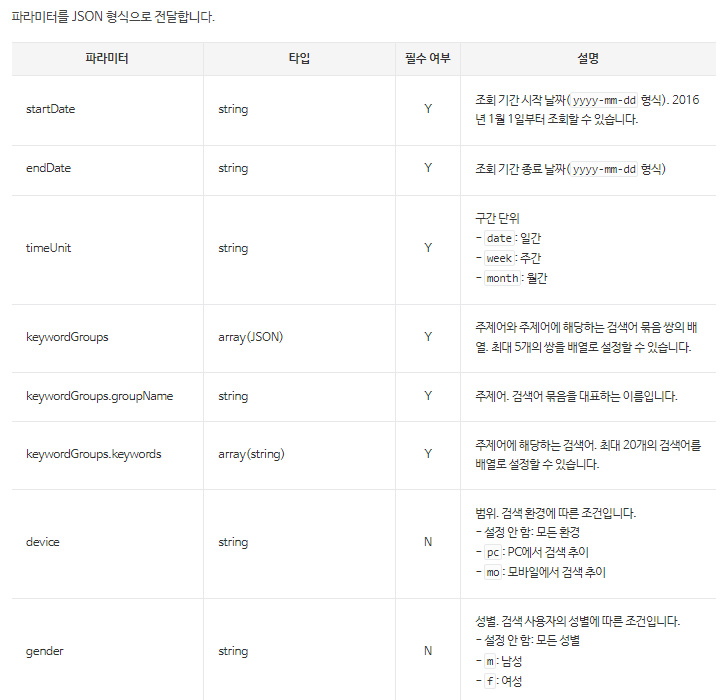

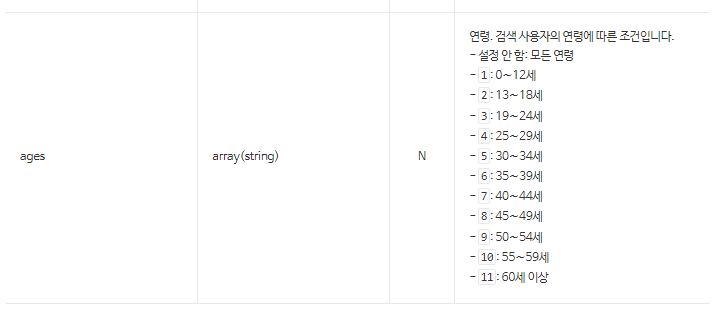

- 반복문 활용 휴폐업 기업 (6739개) 에 대한 검색량 가져오기

In [2]:
import pandas as pd
close_dt = pd.read_excel("C:/Users/shcho/Desktop/윤영/sesac/공모전/numble/data/휴폐업 중소법인 재무보유.xlsx",sheet_name = '기업개요')
close_dt['CMP_NM'] =close_dt['CMP_NM'].astype(str) # 문자열로 변환
#close_dt['close']='Y'
close_name=close_dt['CMP_NM'].values.tolist()

print(len(close_dt['BIZ_NO']))#전체 휴폐업 기업수
close_dt.head()

6739


,BIZ_NO,CMP_PFIX_NM,CMP_NM,CMP_SFIX_NM,CMP_ENM,BZ_TYP,CMP_SCL,PBCO_GB,PSN_CORP_GB,HDOF_BR_GB,...,MDSCO_PRTC_YN,HDOF_CMP_CD,ESTB_DATE,ESTB_GB,LIST_DATE,MN_BIZ_CONT,NATN_NM,HOMEPAGE_URL,CEO_NM,EMP_CNT
0,1268145633,(주),용진테크,NaN,"Yongjin Tech Co., Ltd.",M,2,2,1,1,...,N,NaN,20000529.0,1,NaN,자동차부품 제조판매업,NaN,www.yongjintech.com,안상동,40.0
1,1388101749,NaN,신구건설,(주),"SHINKU C0NSTRUCTION CO.,LTD.",M,2,2,1,1,...,N,NaN,19850110.0,1,NaN,건축자재 판매업,NaN,www.shinku.co.kr,소재필,13.0
2,1068179240,(주),석정미디어,NaN,sung jung,M,2,2,1,1,...,N,NaN,19990601.0,1,NaN,"토너, 잉크, 프린터 외 컴퓨터 관련 주변기기",NaN,NaN,이상호,1.0
3,2248114507,(주),새한실업,NaN,"SAEHAN INDUSTRY CO.,LTD.",M,2,2,1,1,...,N,NaN,19980522.0,1,NaN,금속 캔 및 기타 포장용기 제조업,NaN,NaN,김정남외 1명,6.0
4,1168132785,(주),석영엔터프라이즈,NaN,"Seokyoung Enterprise Co.,Ltd.",M,2,2,1,1,...,N,NaN,19930226.0,1,NaN,스마트트레이 외,NaN,www.systeel.co.kr,박성진,40.0


- for문 돌면서 데이터 쌓기
- 기업별 검색량 데이터 프레임 하나씩 받아옴(period,검색량)
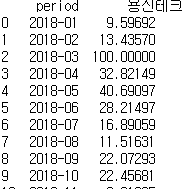

- 빈 데이터의 경우 미리 만들어 준 연-월 날짜 데이터(dates_df)을 기준으로 merge

- period빈 데이터 예 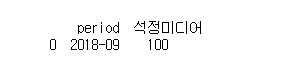

- append로 검색량값 데이터만 뽑아서 concat
- 각각 append->concat 시키면서 열기준 (axis=1)붙이기 
- 마지막에 날짜데이터(dates_df)랑 concat

## 5개 돌려보기

In [26]:
#반복문 활용 전체코드
import json
import pandas as pd
import matplotlib.pyplot as plt
#-*- coding: utf-8 -*-
import os
import sys
import urllib.request


#최대 4년 간 연간날짜 칼럼만들기(%Y-%m)

dates = pd.period_range('2018-01','2021-12',freq='M')
dates_df=dates.to_frame(index=False, name='period')
dates_df['period']=dates_df['period'].astype(str)#속성 object로 통일하기


#월별 검색량 데이터 가져오기

client_id = "_fhVEKEqjPXpFnAqhvEv"
client_secret = "MwcgpgH7E9"
url = "https://openapi.naver.com/v1/datalab/search";

#검색량 값을 받기위한 빈리스트
new_df=[] 


for i in close_name[:5]:
    
    body = {
    "startDate":"2018-01-01"
        ,"endDate":"2021-12-31",
        "timeUnit":"month",
            "keywordGroups":[
                {"groupName":str(i),"keywords":[str(i)]},
            ],
                }
    
    body=json.dumps(body)
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    rescode = response.getcode()
    json_obj= json.loads(response.read().decode('utf-8'))

    if(rescode==200):
        response_body = response.read()
        print(response_body.decode('utf-8'))
    else:
        print("Error Code:" + rescode)
    #json_obj
    
    #list로 옆으로 쌓기
    



    #'석정미디어'의 경우 json으로 추출시 2018-09 데이터 하나만 추출됨.
    # #데이터 프레임 데이터 받아 온 루 period기준으로 merge 
    
    df1=pd.DataFrame(json_obj['results'][0]['data'])
    df1.columns=['period',str('keywords')]
    df1['period']=pd.to_datetime(df1['period'], format='%Y-%m-%d')
    df1['period']=df1['period'].dt.strftime('%Y-%m')
    df1['period']=df1['period'].astype(str) #속성 object로 통일하기
    df1.rename(columns = {'keywords':str(i)},inplace=True) #기업명으로 칼럼명 변경
    temp_dt=pd.merge(dates_df,df1,how='left',on='period').fillna(0)
    
    # 검색량 데이터만 뽑아서 concat하기위해 값만 append
    new_df.append(temp_dt.iloc[:,1])
    
    #print(new_df)

# 각각 append->concat 시키면서 열기준 (axis=1)붙이기 
search_dt=pd.concat(new_df,axis=1)
print(search_dt)


# 마지막에 날짜데이터(dates_df)랑 concat
fin_search_dt=pd.concat([dates_df,search_dt],axis=1)
print(fin_search_dt)







         용진테크       신구건설  석정미디어       새한실업   석영엔터프라이즈
0     9.59692  100.00000    0.0    0.00000  100.00000
1    13.43570   54.02476    0.0    0.00000   48.14814
2   100.00000   71.59442    0.0    0.00000   48.67724
3    32.82149   96.82662    0.0   92.30769   47.08994
4    40.69097   96.51702    0.0   38.46153   31.74603
5    28.21497   45.58823    0.0   76.92307   39.15343
6    16.89059   52.01238    0.0    0.00000   49.20634
7    11.51631   53.01857    0.0    0.00000   59.78835
8    22.07293   40.32507  100.0    0.00000   43.91534
9    22.45681   35.99071    0.0    0.00000   47.08994
10    9.21305   30.65015    0.0    0.00000   38.09523
11   21.30518   24.61300    0.0    0.00000   33.86243
12   24.18426   28.40557    0.0    0.00000   42.32804
13   13.62763   20.97523    0.0    0.00000   43.91534
14   25.71976   29.33436    0.0    0.00000   74.60317
15   27.25527   22.75541    0.0    0.00000   66.66666
16   17.27447   24.53560    0.0    0.00000   69.84126
17    9.02111   23.9938

## 1000개 돌려보기
- 하루 1000번 까지 api 호출제한
- 221015 : 633개까지 불러옴.

In [34]:
#반복문 활용 전체코드
import json
import pandas as pd
import matplotlib.pyplot as plt
#-*- coding: utf-8 -*-
import os
import sys
import urllib.request


#최대 4년 간 연간날짜 칼럼만들기(%Y-%m)

dates = pd.period_range('2018-01','2021-12',freq='M')
dates_df=dates.to_frame(index=False, name='period')
dates_df['period']=dates_df['period'].astype(str)#속성 object로 통일하기


#월별 검색량 데이터 가져오기

client_id = "_fhVEKEqjPXpFnAqhvEv"
client_secret = "MwcgpgH7E9"
url = "https://openapi.naver.com/v1/datalab/search";

#검색량 값을 받기위한 빈리스트
new_df=[] 


for i in close_name:
    
    try:

        body = {
        "startDate":"2018-01-01"
            ,"endDate":"2021-12-31",
            "timeUnit":"month",
                "keywordGroups":[
                    {"groupName":str(i),"keywords":[str(i)]},
                ],
                    }

        body=json.dumps(body)
        request = urllib.request.Request(url)
        request.add_header("X-Naver-Client-Id",client_id)
        request.add_header("X-Naver-Client-Secret",client_secret)
        request.add_header("Content-Type","application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        json_obj= json.loads(response.read().decode('utf-8'))
    


        if(rescode==200):
            response_body = response.read()
            print(response_body.decode('utf-8'))
        else:
            print("Error Code:" + rescode)
    #json_obj

    #list로 옆으로 쌓기


        #'석정미디어'의 경우 json으로 추출시 2018-09 데이터 하나만 추출됨.
        # #데이터 프레임 데이터 받아 온 루 period기준으로 merge 

        df1=pd.DataFrame(json_obj['results'][0]['data'])
        df1.columns=['period',str('keywords')]
        df1['period']=pd.to_datetime(df1['period'], format='%Y-%m-%d')
        df1['period']=df1['period'].dt.strftime('%Y-%m')
        df1['period']=df1['period'].astype(str) #속성 object로 통일하기
        df1.rename(columns = {'keywords':str(i)},inplace=True) #기업명으로 칼럼명 변경
        temp_dt=pd.merge(dates_df,df1,how='left',on='period').fillna(0)

        # 검색량 데이터만 뽑아서 concat하기위해 값만 append
        new_df.append(temp_dt.iloc[:,1])

        #print(new_df)
    except:
        print(str(i),' 검색량 아예없음!!!')


# 각각 append->concat 시키면서 열기준 (axis=1)붙이기 
search_dt=pd.concat(new_df,axis=1)
search_dt



# 마지막에 날짜데이터(dates_df)랑 concat
fin_search_dt=pd.concat([dates_df,search_dt],axis=1)
fin_search_dt









한일물산(주)서울직매장  검색량 아예없음!!!




하랑그룹  검색량 아예없음!!!






























상현종합조경  검색량 아예없음!!!












청호에스엔지호남  검색량 아예없음!!!
















해날건설  검색량 아예없음!!!

마이크로에스엔브이콘트롤  검색량 아예없음!!!

















지엔에스엠엔씨  검색량 아예없음!!!




































청호에스엔지경남  검색량 아예없음!!!








제이에스텔레트로닉스  검색량 아예없음!!!






















경기시설관리  검색량 아예없음!!!





송산전력  검색량 아예없음!!!





























동백영농조합법인  검색량 아예없음!!!


















영농조합법인한국화훼센타  검색량 아예없음!!!


영신양돈영농조합법인  검색량 아예없음!!!






































한울설비건설  검색량 아예없음!!!


휴링크코리아  검색량 아예없음!!!

























제노사피엔스  검색량 아예없음!!!






한스화학  검색량 아예없음!!!




원이엔지산업  검색량 아예없음!!!












에프에스통상  검색량 아예없음!!!








석하개발1  검색량 아예없음!!!















엔디에스개발  검색량 아예없음!!!




























동아스틸(주)광양공장  검색량 아예없음!!!


지엠종합물류  검색량 아예없음!!!










여래종합통신  검색량 아예없음!!!











한욱테크노글라스주식회사  검색량 아예없음!!!







텔레마스테크놀로지  검색량 아예없음!!!





신원커피물류  검색량 아예없음!!!



정보티브이  검색량 아예없음!!!

삼신이앤비테크노마트점  검색량 아예없음!!!
이랜드크루즈둑도나루  검색량 아예없음!!!
소모에너지엔테크놀러지  검색량 아예없음!!!
헤펠레코리아  검색량 아예없음!!!
경일석유(주)직영삼방주유소  검색량 아예없음!!!
삼양에프앤비  검색량 아예없음!!!
대현유통홍천강(하)주유소  검색량 아예없음!!!
전기공사공제(목포)  검색량 아예없음!!!
전기공사공제(순천)  검색량 아예없음!!!
아이비씨통상부산점  검색량 아예없음!!!
에프씨엔에드가야  검색량 아예없음!!!
신신상사(주)부산지점  검색량 아예없음!!!
아이비씨통산디자인젬  검색량 아예없음!!!
동방석유(주)울산관문주유소  검색량 아예없음!!!
아이비씨쥬얼리롯데울산점  검색량 아예없음!!!
우리영농조합지수분소  검색량 아예없음!!!
전기공사공제조합(진주)  검색량 아예없음!!!
화창상사(주)부산지점  검색량 아예없음!!!
은마석유(주)직영용당씨와이주유  검색량 아예없음!!!
델타타우코리아  검색량 아예없음!!!
청호에스엔지경원  검색량 아예없음!!!
컨시드  검색량 아예없음!!!
장덕개발  검색량 아예없음!!!
동아전력  검색량 아예없음!!!
에스엠커머스  검색량 아예없음!!!
토피스  검색량 아예없음!!!
한유주택  검색량 아예없음!!!
오펙메이드인터내셔널  검색량 아예없음!!!
피에스  검색량 아예없음!!!
연안식품  검색량 아예없음!!!
한림종합상사  검색량 아예없음!!!
에스제이물류  검색량 아예없음!!!
비아이티에코루브  검색량 아예없음!!!
합동영화(주)서울극장  검색량 아예없음!!!
한흥물산  검색량 아예없음!!!
서미트  검색량 아예없음!!!
포탈하이웨이반원지점  검색량 아예없음!!!
코콤서울지점  검색량 아예없음!!!
대한파카라이징  검색량 아예없음!!!
동양잉크제이공장  검색량 아예없음!!!
천마콘크리트공업(주)광주공장  검색량 아예없음!!!
보성공업자동차사업소  검색량 아예없음!!!
동진기업(주)양주공장  검색량 아예없음!!!
뱅뱅어패럴의정부점  검색량 아예없음!!!
현대통신  검색량 

아이비김영  검색량 아예없음!!!
에스엠티코리아  검색량 아예없음!!!
일등안전종합상사  검색량 아예없음!!!
위더스케미칼안성지점  검색량 아예없음!!!
삼해야마코(주)부안공장  검색량 아예없음!!!
갤러리아건설  검색량 아예없음!!!
와이시엘  검색량 아예없음!!!
에스엠에프앤비디벨롭먼트  검색량 아예없음!!!
트니트니  검색량 아예없음!!!
인피니티엔피에스제일호위탁관리부동산투자회사  검색량 아예없음!!!
봉황건설  검색량 아예없음!!!
이더  검색량 아예없음!!!
사우스밸리  검색량 아예없음!!!
에이치에스라이프  검색량 아예없음!!!
세영인더스트리  검색량 아예없음!!!
이촌회계법인호남지점  검색량 아예없음!!!
씨엠텍  검색량 아예없음!!!
지엠  검색량 아예없음!!!
대륭블루텍  검색량 아예없음!!!
솔비어패럴  검색량 아예없음!!!
진유  검색량 아예없음!!!
지비글로벌  검색량 아예없음!!!
대명폴  검색량 아예없음!!!
진로우성물산  검색량 아예없음!!!
디앤스포츠  검색량 아예없음!!!
시즈앤크루즈  검색량 아예없음!!!
골든컴퍼스투자자문  검색량 아예없음!!!
에비앙  검색량 아예없음!!!
오믹시스  검색량 아예없음!!!
신우전기엔지니어링  검색량 아예없음!!!
다옴엔지니어링  검색량 아예없음!!!
상록건설  검색량 아예없음!!!
그랜드블루  검색량 아예없음!!!
씨엠알기술연구원  검색량 아예없음!!!
인벤티홀딩스  검색량 아예없음!!!
스토바씨앤디  검색량 아예없음!!!
판교에스디투  검색량 아예없음!!!
티에스트릴리온  검색량 아예없음!!!
양우산업개발  검색량 아예없음!!!
에스지데이타  검색량 아예없음!!!
영인에이티  검색량 아예없음!!!
에이스메카텍  검색량 아예없음!!!
아이내추럴  검색량 아예없음!!!
삼우디앤씨  검색량 아예없음!!!
와이케이내쇼날  검색량 아예없음!!!
우성케미칼  검색량 아예없음!!!
의성기계  검색량 아예없음!!!
구상산업개발  검색량 아예없음!!!
한섬산업개발  검색량 아예없음!!!
대명호텔앤리조트천안 

정플러스여행사  검색량 아예없음!!!
중앙에이치에스  검색량 아예없음!!!
성민티엔디  검색량 아예없음!!!
피비케미칼  검색량 아예없음!!!
태현이엔지  검색량 아예없음!!!
화신기계상사부산지점  검색량 아예없음!!!
라이즈스틸  검색량 아예없음!!!
고운하이츠  검색량 아예없음!!!
에스에이치비쥬얼  검색량 아예없음!!!
대도상회  검색량 아예없음!!!
에치케이텍  검색량 아예없음!!!
케이디시스텍  검색량 아예없음!!!
화인이앤지  검색량 아예없음!!!
엠에스티코리아  검색량 아예없음!!!
굿스틸  검색량 아예없음!!!
원광도어  검색량 아예없음!!!
코리아환경스마트  검색량 아예없음!!!
세중  검색량 아예없음!!!
혜원종합건축사사무소  검색량 아예없음!!!
수정  검색량 아예없음!!!
썸덱스월드  검색량 아예없음!!!
태광공업  검색량 아예없음!!!
어진철강시흥영업소  검색량 아예없음!!!
한국커피물류  검색량 아예없음!!!
프리즘  검색량 아예없음!!!
썬앤쉴드  검색량 아예없음!!!
태광공업(주)화성공장  검색량 아예없음!!!
경남창호  검색량 아예없음!!!
동경  검색량 아예없음!!!
청우식품북부영업소  검색량 아예없음!!!
이생테크건설  검색량 아예없음!!!
서영신소재  검색량 아예없음!!!
금원물류  검색량 아예없음!!!
고려은단  검색량 아예없음!!!
토마텍  검색량 아예없음!!!
한우리외식산업  검색량 아예없음!!!
대호레포츠  검색량 아예없음!!!
제이타우젠트  검색량 아예없음!!!
우림엔지니어링건축사사무소  검색량 아예없음!!!
현우산기  검색량 아예없음!!!
세화개발  검색량 아예없음!!!
삼포식품  검색량 아예없음!!!
상지정공제천지점  검색량 아예없음!!!
미주공업  검색량 아예없음!!!
포나후렉스천안사업장  검색량 아예없음!!!
천우테크장항공장  검색량 아예없음!!!
비엠시스  검색량 아예없음!!!
국제에스티  검색량 아예없음!!!
은백  검색량 아예없음!!!
일우영농조합법인  검색량 아예없음!!!
청우식품포항영업소  검색량 아

월드석재산업  검색량 아예없음!!!
삼현이엔에스  검색량 아예없음!!!
이공엔지니어링  검색량 아예없음!!!
인앤인시스템  검색량 아예없음!!!
진덕공사  검색량 아예없음!!!
미건  검색량 아예없음!!!
새한이앤에스  검색량 아예없음!!!
자오  검색량 아예없음!!!
서호토건  검색량 아예없음!!!
코디아이  검색량 아예없음!!!
알로드  검색량 아예없음!!!
농업회사법인한솔에프앤비  검색량 아예없음!!!
하이네트웍스  검색량 아예없음!!!
바이웹  검색량 아예없음!!!
티앤씨팜  검색량 아예없음!!!
홍우비앤티안성지점  검색량 아예없음!!!
바루소프트  검색량 아예없음!!!
케이알제5호위탁관리부동산투자회사  검색량 아예없음!!!
해커스종로  검색량 아예없음!!!
오토이십오시종합자동차서비스  검색량 아예없음!!!
해우림  검색량 아예없음!!!
동북쇼핑  검색량 아예없음!!!
에스아이시스템  검색량 아예없음!!!
오앤케이테크  검색량 아예없음!!!
베네스킨코스메틱  검색량 아예없음!!!
에이치티씨까사빌신촌  검색량 아예없음!!!
진도에프앤청담점  검색량 아예없음!!!
태정전척  검색량 아예없음!!!
에이프로젠케이아이씨포항플랜트지점  검색량 아예없음!!!
크리  검색량 아예없음!!!
담터대궁영업  검색량 아예없음!!!
조흥  검색량 아예없음!!!
코리아프리프로그래픽앤씨스템  검색량 아예없음!!!
성심투자개발  검색량 아예없음!!!
제이더블유엘  검색량 아예없음!!!
산청식품  검색량 아예없음!!!
코온  검색량 아예없음!!!
주아성테크노대구지점  검색량 아예없음!!!
세아테크  검색량 아예없음!!!
대진금속  검색량 아예없음!!!
디지털프라자금천지점  검색량 아예없음!!!
디자인미래감  검색량 아예없음!!!
에스엘테크  검색량 아예없음!!!
효종원  검색량 아예없음!!!
우영에이텍  검색량 아예없음!!!
제오젠  검색량 아예없음!!!
파인  검색량 아예없음!!!
윤우정밀  검색량 아예없음!!!
에이알에이엔피에스제2호위탁관리부동산투자회사  검색량 아예없음!!!
이

토너테크  검색량 아예없음!!!
재화  검색량 아예없음!!!
쥬비트  검색량 아예없음!!!
한결  검색량 아예없음!!!
지테크  검색량 아예없음!!!
이에스에스이  검색량 아예없음!!!
우진침구  검색량 아예없음!!!
건영이앤씨  검색량 아예없음!!!
한서공조  검색량 아예없음!!!
마무트코리아동대문점  검색량 아예없음!!!
마무트코리아청계산점  검색량 아예없음!!!
마무트코리아대전둔산지점  검색량 아예없음!!!
마무트코리아대구수성점  검색량 아예없음!!!
삼포실버드림  검색량 아예없음!!!
삼포실버드림  검색량 아예없음!!!
삼포실버드림국립의료원  검색량 아예없음!!!
삼포실버드림  검색량 아예없음!!!
삼포실버드림연세장례식장  검색량 아예없음!!!
굿모닝세무법인  검색량 아예없음!!!
위드이엔씨  검색량 아예없음!!!
엘에이치마이홈사차유동화전문  검색량 아예없음!!!
제이앤제이트레이딩  검색량 아예없음!!!
게임빈  검색량 아예없음!!!
유성테크닉스  검색량 아예없음!!!
우정마늘농산  검색량 아예없음!!!
일진엠에이시  검색량 아예없음!!!
아디아  검색량 아예없음!!!
디엔에프스틸  검색량 아예없음!!!
본아이온  검색량 아예없음!!!
에스디금속  검색량 아예없음!!!
무진전력  검색량 아예없음!!!
서현종합건설  검색량 아예없음!!!
금석해운  검색량 아예없음!!!
아이홈시스  검색량 아예없음!!!
삼성홈마트  검색량 아예없음!!!
스카이  검색량 아예없음!!!
오픈정보기술(주)지점  검색량 아예없음!!!
본오  검색량 아예없음!!!
자이크로  검색량 아예없음!!!
삼미산업  검색량 아예없음!!!
소해하우징  검색량 아예없음!!!
그린월드  검색량 아예없음!!!
홍지원  검색량 아예없음!!!
디에스코텍  검색량 아예없음!!!
씨엔씨알  검색량 아예없음!!!
상원이노텍  검색량 아예없음!!!
뉴에너지파워  검색량 아예없음!!!
성찬종합건설  검색량 아예없음!!!
세종머티리얼즈(주)제이공장  검색량 아예없음!!!
시원  검색량 아예없음!!!
제이앤제이산업

이상종합건설  검색량 아예없음!!!
아베크인터내셔널  검색량 아예없음!!!
새로본  검색량 아예없음!!!
케이원제2호위탁관리부동산투자회사  검색량 아예없음!!!
에스앤알  검색량 아예없음!!!
유안개발  검색량 아예없음!!!
케이비더블유  검색량 아예없음!!!
디에스아이  검색량 아예없음!!!
해온테크놀로지  검색량 아예없음!!!
세일에프엠  검색량 아예없음!!!
주영  검색량 아예없음!!!
반고푸드시스템  검색량 아예없음!!!
부성코오드  검색량 아예없음!!!
정가온  검색량 아예없음!!!
동진캐스팅  검색량 아예없음!!!
태성화학  검색량 아예없음!!!
우미건설산업  검색량 아예없음!!!
에픽  검색량 아예없음!!!
비와이앤씨  검색량 아예없음!!!
케이엠이  검색량 아예없음!!!
지엠라이팅  검색량 아예없음!!!
송추가마골  검색량 아예없음!!!
코스레보  검색량 아예없음!!!
언드레스  검색량 아예없음!!!
유저해빗  검색량 아예없음!!!
브이엠팩토리  검색량 아예없음!!!
우성엔터테인먼트  검색량 아예없음!!!
디디앤컴퍼니  검색량 아예없음!!!
데일리  검색량 아예없음!!!
판디엔씨  검색량 아예없음!!!
아이메탈  검색량 아예없음!!!
태화개발  검색량 아예없음!!!
파이리퀴드  검색량 아예없음!!!
명품정항우케익  검색량 아예없음!!!
디비에스아이  검색량 아예없음!!!
우성공영  검색량 아예없음!!!
엘케이코리아에프엔비  검색량 아예없음!!!
덤퍼  검색량 아예없음!!!
티엔에스토탈컨설팅  검색량 아예없음!!!
제이알제13호위탁관리부동산투자회사  검색량 아예없음!!!
북앤북스  검색량 아예없음!!!
씨아이씨티  검색량 아예없음!!!
지오유통  검색량 아예없음!!!
농부와콩  검색량 아예없음!!!
호수조명  검색량 아예없음!!!
보성목재  검색량 아예없음!!!
오성  검색량 아예없음!!!
아이존옵틱  검색량 아예없음!!!
부르조아가구  검색량 아예없음!!!
먹킷  검색량 아예없음!!!
버자야에이치알카페코리아  검색량 아예없음!!!
호텔머드린  검

온더보더일산원마운트점  검색량 아예없음!!!
러쉬코리아강남점  검색량 아예없음!!!
후지유통(주)부천역사  검색량 아예없음!!!
소모석유뉴오남주유소  검색량 아예없음!!!
동일유업(주)모현충전소  검색량 아예없음!!!
엔에스에프가로수길  검색량 아예없음!!!
브레댄코서울성모병원점  검색량 아예없음!!!
인석해운대지점  검색량 아예없음!!!
마이크임팩트스퀘어종로점  검색량 아예없음!!!
소모석유광장주유소  검색량 아예없음!!!
이티앤제우스불고기브라더스  검색량 아예없음!!!
중앙에너비스왕십리지점  검색량 아예없음!!!
씨스페이시스부평동아  검색량 아예없음!!!
씨스페이시스미아삼점  검색량 아예없음!!!
데일리굿푸드시스템(지점)  검색량 아예없음!!!
성대유통(부천지점)  검색량 아예없음!!!
마노핀익스프레스신림역점  검색량 아예없음!!!
오에스에너지주공셀프주유소  검색량 아예없음!!!
하모니리테일김포점  검색량 아예없음!!!
한솥강남역점  검색량 아예없음!!!
대양산업(주)대양울산충전소  검색량 아예없음!!!
아트박스건대점  검색량 아예없음!!!
제이에스  검색량 아예없음!!!
제스텍  검색량 아예없음!!!
거백  검색량 아예없음!!!
레이전트리제주  검색량 아예없음!!!
용당일반산업단지  검색량 아예없음!!!
스마트로직  검색량 아예없음!!!
아트박스홍대점  검색량 아예없음!!!
영농조합법인학사농장수완점  검색량 아예없음!!!
홀리카홀리카산본점  검색량 아예없음!!!
시몬느에프씨  검색량 아예없음!!!
씨스페이시스터미널점  검색량 아예없음!!!
씨스페이스유성봉명점  검색량 아예없음!!!
디지털프라자철원점  검색량 아예없음!!!
에듀윌  검색량 아예없음!!!
후지유통(주)분당점  검색량 아예없음!!!
홀리카홀리카(일산화정점)  검색량 아예없음!!!
홀리카홀리카(용인수지점)  검색량 아예없음!!!
호남산업(주)호남주유소  검색량 아예없음!!!
후지유통(주)성서점  검색량 아예없음!!!
씨스페이스(상인점)  검색량 아예없음!!!
엠에스씨  검색량 아예없음!!!
제주

청운디자인그룹  검색량 아예없음!!!
아트로  검색량 아예없음!!!
우진인솔  검색량 아예없음!!!
더제이투시스템  검색량 아예없음!!!
영수산업개발  검색량 아예없음!!!
남명  검색량 아예없음!!!
에이비온바이오메드  검색량 아예없음!!!
두남전력하늘빌  검색량 아예없음!!!
씨티레져산업  검색량 아예없음!!!
디유닛  검색량 아예없음!!!
대영에스에프  검색량 아예없음!!!
디웍스앤컴퍼니  검색량 아예없음!!!
아이콘서플라이컴퍼니  검색량 아예없음!!!
서원관리  검색량 아예없음!!!
휴메인시스템  검색량 아예없음!!!
레드모바일  검색량 아예없음!!!
주연어패럴  검색량 아예없음!!!
풍산레이저코리아  검색량 아예없음!!!
솔리드웨어  검색량 아예없음!!!
소울디자인웍스  검색량 아예없음!!!
대산기술  검색량 아예없음!!!
경동솔라  검색량 아예없음!!!
조은포크농업회사법인  검색량 아예없음!!!
탑앤씨  검색량 아예없음!!!
아이솝  검색량 아예없음!!!
예스신환  검색량 아예없음!!!
하우이씨엠  검색량 아예없음!!!
하늘기업동해연구소및공장  검색량 아예없음!!!
대현하이텍충주이공장  검색량 아예없음!!!
뉴스타  검색량 아예없음!!!
콤파  검색량 아예없음!!!
로쉬  검색량 아예없음!!!
열린  검색량 아예없음!!!
재인컴포드  검색량 아예없음!!!
제이피푸드  검색량 아예없음!!!
바다물산  검색량 아예없음!!!
여민  검색량 아예없음!!!
팬톤에이디  검색량 아예없음!!!
에이치엘커머스  검색량 아예없음!!!
킹스테이블  검색량 아예없음!!!
제일피엔이  검색량 아예없음!!!
삼미건설  검색량 아예없음!!!
모두이엔씨  검색량 아예없음!!!
유진공조  검색량 아예없음!!!
헤브론  검색량 아예없음!!!
대교산업개발  검색량 아예없음!!!
성산프로폴  검색량 아예없음!!!
청보산업개발  검색량 아예없음!!!
참푸드  검색량 아예없음!!!
청보  검색량 아예없음!!!
갑부농산  검색량 아예없음!!!
송추가마골구월지점  검색량 아예없음!!!
에이

보성테크종각지점  검색량 아예없음!!!
삼보물류구도일주유소솔향강릉  검색량 아예없음!!!
젯아이씨(주)물류센터  검색량 아예없음!!!
깨스코평택씨엔지  검색량 아예없음!!!
꼬끼오고촌지점  검색량 아예없음!!!
보성테크동대문지점  검색량 아예없음!!!
자리(주)선유도지점  검색량 아예없음!!!
아이비김영동대문지점  검색량 아예없음!!!
브레댄코비알씨디스타시티  검색량 아예없음!!!
이렌트카문래지점  검색량 아예없음!!!
에프씨엔애드검단점  검색량 아예없음!!!
브이티코스메틱  검색량 아예없음!!!
오대케이  검색량 아예없음!!!
운하리조트  검색량 아예없음!!!
디케이비엠시  검색량 아예없음!!!
에스디홍대지점  검색량 아예없음!!!
미스터피자여의도점  검색량 아예없음!!!
엔에이치유통(주)부안하쉼터지점  검색량 아예없음!!!
케이엔알동대문지점  검색량 아예없음!!!
에프씨엔애드울산동구점  검색량 아예없음!!!
스튜디오다산  검색량 아예없음!!!
비와이씨마트장안지점  검색량 아예없음!!!
정현회계법인지점  검색량 아예없음!!!
말타니  검색량 아예없음!!!
대구하이테크  검색량 아예없음!!!
신화홀딩스  검색량 아예없음!!!
플랜위너스  검색량 아예없음!!!
다래마을  검색량 아예없음!!!
세상  검색량 아예없음!!!
지오위드  검색량 아예없음!!!
포스컨트롤  검색량 아예없음!!!
티제이건설  검색량 아예없음!!!
대흥농산북부  검색량 아예없음!!!
마린스페이스  검색량 아예없음!!!
에코리더  검색량 아예없음!!!
한라푸드  검색량 아예없음!!!
농업회사법인무안꿈여울  검색량 아예없음!!!
영앤진회계법인경기지점  검색량 아예없음!!!
영앤진회계법인  검색량 아예없음!!!
이지스지점  검색량 아예없음!!!
로봇앤휴먼네트웍스  검색량 아예없음!!!
지형레미콘  검색량 아예없음!!!
라온텍  검색량 아예없음!!!
라바꼬레아  검색량 아예없음!!!
성산레미콘  검색량 아예없음!!!
아이두트레이딩  검색량 아예없음!!!
지스타코리아  검색량 아예없음!!!
문서지기 

특허법인참좋은  검색량 아예없음!!!
지케이돔하우스  검색량 아예없음!!!
현대철강  검색량 아예없음!!!
태광건업  검색량 아예없음!!!
디케이비즈  검색량 아예없음!!!
동명바이오  검색량 아예없음!!!
아람  검색량 아예없음!!!
포차어게인  검색량 아예없음!!!
제이앤인터내셔널  검색량 아예없음!!!
가창로지스틱스파크프로젝트금융투자  검색량 아예없음!!!
데이터브릭  검색량 아예없음!!!
우수솔루션  검색량 아예없음!!!
리케커뮤니케이션즈  검색량 아예없음!!!
에이치앤영  검색량 아예없음!!!
종합건설바른  검색량 아예없음!!!
네고  검색량 아예없음!!!
삼형제정비공업사  검색량 아예없음!!!
더팩트컴퍼니  검색량 아예없음!!!
이피에스솔루션  검색량 아예없음!!!
에프티이앤이  검색량 아예없음!!!
화성도시피에프브이  검색량 아예없음!!!
브릿지톤개발  검색량 아예없음!!!
엠제이컨텍  검색량 아예없음!!!
프로비던스원  검색량 아예없음!!!
리아모  검색량 아예없음!!!
케이앤에프  검색량 아예없음!!!
씨케이클린텍  검색량 아예없음!!!
비에프티  검색량 아예없음!!!
도담종합건설  검색량 아예없음!!!
슈웍스  검색량 아예없음!!!
보보상사  검색량 아예없음!!!
위드크로스  검색량 아예없음!!!
한일전기  검색량 아예없음!!!
디비엠제이  검색량 아예없음!!!
이엠테크놀리지  검색량 아예없음!!!
다밀  검색량 아예없음!!!
나래에프엔비  검색량 아예없음!!!
동아정공  검색량 아예없음!!!
세진소방  검색량 아예없음!!!
삼일금속  검색량 아예없음!!!
현대성우메탈(주)충주공장  검색량 아예없음!!!
영재정공  검색량 아예없음!!!
케이디파워김포지점  검색량 아예없음!!!
유니크건설(주)파주지점  검색량 아예없음!!!
더블와이에스컴퍼니  검색량 아예없음!!!
스카이라이트  검색량 아예없음!!!
경도이엔씨  검색량 아예없음!!!
진호테크  검색량 아예없음!!!
포엠코리아  검색량 아예없음!!!
태영  검색량 아예없음!!!
티오에스산업  검색

성지로보텍  검색량 아예없음!!!
엔에스비  검색량 아예없음!!!
바우스에이앤디  검색량 아예없음!!!
프로핏대부  검색량 아예없음!!!
한돌바이오텍  검색량 아예없음!!!
혜우산업개발  검색량 아예없음!!!
트릴런  검색량 아예없음!!!
알파비앤에이치  검색량 아예없음!!!
태안에너지  검색량 아예없음!!!
수퍼브  검색량 아예없음!!!
대영테크  검색량 아예없음!!!
선일세라믹스  검색량 아예없음!!!
대한하이텍  검색량 아예없음!!!
깐부  검색량 아예없음!!!
아즈텍더블유비이  검색량 아예없음!!!
리오엘리해운대지점유성  검색량 아예없음!!!
뉴텍씨엔브이(주)지점  검색량 아예없음!!!
브렉스랩  검색량 아예없음!!!
두리반팜  검색량 아예없음!!!
수림물류  검색량 아예없음!!!
아코스트레이딩  검색량 아예없음!!!
엑시스  검색량 아예없음!!!
농업법인이안  검색량 아예없음!!!
가로커뮤니케이션  검색량 아예없음!!!
에이치투컴퍼니  검색량 아예없음!!!
온코파마텍  검색량 아예없음!!!
한강케이씨  검색량 아예없음!!!
정현하이텍  검색량 아예없음!!!
디자인드디자인  검색량 아예없음!!!
비엔피서비스  검색량 아예없음!!!
양호청주지점  검색량 아예없음!!!
신성이엔지  검색량 아예없음!!!
리모트솔루션(주)군포지점  검색량 아예없음!!!
인츠넷  검색량 아예없음!!!
비씨콘  검색량 아예없음!!!
즐거운사람들  검색량 아예없음!!!
휴먼매니지먼트컴퍼니  검색량 아예없음!!!
이엠씨홀딩스  검색량 아예없음!!!
환경화학  검색량 아예없음!!!
바나나이앤에스  검색량 아예없음!!!
카와  검색량 아예없음!!!
휘포스  검색량 아예없음!!!
마루건설기계  검색량 아예없음!!!
뉴비즈코리아  검색량 아예없음!!!
대명광학(주)오창공장  검색량 아예없음!!!
아이비텍(주)부산지점  검색량 아예없음!!!
농업회사법인국보플러스  검색량 아예없음!!!
에움넷  검색량 아예없음!!!
양주옥정3차주택위탁관리부동산투자회사  검색량 아예없음!!!
애드텍  검색량 아

조이핀  검색량 아예없음!!!
마크원인베스트먼트  검색량 아예없음!!!
미디어튠  검색량 아예없음!!!
에코앰넷  검색량 아예없음!!!
네이처리사이클  검색량 아예없음!!!
태금  검색량 아예없음!!!
프라임제이이앤씨  검색량 아예없음!!!
리텍인터내셔널  검색량 아예없음!!!
타이키인베스트먼트  검색량 아예없음!!!
비버스팩토리  검색량 아예없음!!!
현종합건설  검색량 아예없음!!!
태백연탄  검색량 아예없음!!!
상미  검색량 아예없음!!!
비아이  검색량 아예없음!!!
제이와이산업  검색량 아예없음!!!
신원하이텍(주)칠곡지점  검색량 아예없음!!!
더화이트넷  검색량 아예없음!!!
리슨소프트  검색량 아예없음!!!
폴라게임즈  검색량 아예없음!!!
비지에프포스트  검색량 아예없음!!!
대신코리아  검색량 아예없음!!!
창조이엔지  검색량 아예없음!!!
알엠테크  검색량 아예없음!!!
성호정보통신  검색량 아예없음!!!
중경디앤씨  검색량 아예없음!!!
대성제휴  검색량 아예없음!!!
로얄라이프  검색량 아예없음!!!
엔제이  검색량 아예없음!!!
대지  검색량 아예없음!!!
케이엔코리아엘지잠실야구장지점  검색량 아예없음!!!
케이엔코리아한밭야구장점  검색량 아예없음!!!
더릿지354  검색량 아예없음!!!
코바치영등포점  검색량 아예없음!!!
마스턴제20호신사피에프브이  검색량 아예없음!!!
유아이시티  검색량 아예없음!!!
스토리앤브라더스  검색량 아예없음!!!
엠제이브로스  검색량 아예없음!!!
해경건설  검색량 아예없음!!!
다우펀다  검색량 아예없음!!!
은성이엔디  검색량 아예없음!!!
비씨에이치푸드  검색량 아예없음!!!
농부마을  검색량 아예없음!!!
네임북스  검색량 아예없음!!!
빌트모아순천풍덕점  검색량 아예없음!!!
빌트모아영등포점  검색량 아예없음!!!
빌트모아울산점  검색량 아예없음!!!
빌트모아연수점  검색량 아예없음!!!
빌트모아서수원점  검색량 아예없음!!!
빌트모아원주점  검색량 아예없음!!!
빌트모아청라점  검색량 아예

에스씨피기술  검색량 아예없음!!!
배스트  검색량 아예없음!!!
평안  검색량 아예없음!!!
대륜코브라더스피에프브이  검색량 아예없음!!!
거창푸드  검색량 아예없음!!!
케이비죽전알앤디센터위탁관리부동산투자회사  검색량 아예없음!!!
테라피웍스  검색량 아예없음!!!
와이케이헤센  검색량 아예없음!!!
에스엠산업안전  검색량 아예없음!!!
제이웰그린  검색량 아예없음!!!
워텍  검색량 아예없음!!!
플레이세븐  검색량 아예없음!!!
북극성여행사  검색량 아예없음!!!
닷투비  검색량 아예없음!!!
올프스  검색량 아예없음!!!
뮤로엔터테인먼트  검색량 아예없음!!!
에이스안전산업  검색량 아예없음!!!
에이치제이  검색량 아예없음!!!
유창  검색량 아예없음!!!
창덕알씨  검색량 아예없음!!!
다모아관리  검색량 아예없음!!!
바른공방  검색량 아예없음!!!
디자인까사  검색량 아예없음!!!
와이영암마트방림점  검색량 아예없음!!!
에스제이디개발  검색량 아예없음!!!
수라움건설  검색량 아예없음!!!
엠제이글로벌  검색량 아예없음!!!
오에이치  검색량 아예없음!!!
에이치케이인터내셔널  검색량 아예없음!!!
한화에이스기업인수목적4호  검색량 아예없음!!!
업스페이스  검색량 아예없음!!!
오앤영인터내셔날  검색량 아예없음!!!
쏘시오리빙  검색량 아예없음!!!
엘투케이  검색량 아예없음!!!
지의소프트  검색량 아예없음!!!
이지  검색량 아예없음!!!
일우산업  검색량 아예없음!!!
선진환경  검색량 아예없음!!!
지광창호  검색량 아예없음!!!
누리홀딩스  검색량 아예없음!!!
은성메디텍서울지점  검색량 아예없음!!!
엠지플러스  검색량 아예없음!!!
파르  검색량 아예없음!!!
캐럿플랫폼  검색량 아예없음!!!
보우  검색량 아예없음!!!
디엔제이컴퍼니  검색량 아예없음!!!
블루진라이프사이언스  검색량 아예없음!!!
태영이엔지  검색량 아예없음!!!
타이소  검색량 아예없음!!!
킹모터스  검색량 아예없음!!!
굿헬스케어  검색량 아예없음!!!

더블유알디  검색량 아예없음!!!
쥬라리움  검색량 아예없음!!!
아이알에스  검색량 아예없음!!!
레폰메디텍  검색량 아예없음!!!
대일  검색량 아예없음!!!
해자건설  검색량 아예없음!!!
메르칼리시스템  검색량 아예없음!!!
메가프로브  검색량 아예없음!!!
제이제이솔루션  검색량 아예없음!!!
참조은환경  검색량 아예없음!!!
금성알미늄  검색량 아예없음!!!
정서테크  검색량 아예없음!!!
선유도밸리  검색량 아예없음!!!
디엠시티동탄  검색량 아예없음!!!
지디체인  검색량 아예없음!!!
대한에프앤씨  검색량 아예없음!!!
데브시스터즈마스  검색량 아예없음!!!
비포인트  검색량 아예없음!!!
파인더다온  검색량 아예없음!!!
제타큐브사이언스  검색량 아예없음!!!
대유건설  검색량 아예없음!!!
경성산업  검색량 아예없음!!!
코리아정밀  검색량 아예없음!!!
매직아이오티  검색량 아예없음!!!
밸로인  검색량 아예없음!!!
심플랩  검색량 아예없음!!!
셀러  검색량 아예없음!!!
제이에스메탈  검색량 아예없음!!!
본도방  검색량 아예없음!!!
씨스타일  검색량 아예없음!!!
디엔비몰드  검색량 아예없음!!!
농업회사법인(주)영풍지점  검색량 아예없음!!!
행운에프씨  검색량 아예없음!!!
에스에프피씨  검색량 아예없음!!!
에이아이더  검색량 아예없음!!!
다우리애드  검색량 아예없음!!!
에스알티이씨  검색량 아예없음!!!
골드모터스  검색량 아예없음!!!
에이아이플러스  검색량 아예없음!!!
신영피에프브이제2호  검색량 아예없음!!!
다산양식상사  검색량 아예없음!!!
쿼드유  검색량 아예없음!!!
퓨전텍  검색량 아예없음!!!
디자인그룹단  검색량 아예없음!!!
지니어카운트  검색량 아예없음!!!
큐이지  검색량 아예없음!!!
핫마인쓰리디  검색량 아예없음!!!
인피니티  검색량 아예없음!!!
클래스마켓  검색량 아예없음!!!
지인유동화제구차  검색량 아예없음!!!
그린유지보수건설  검색량 아예없음!!!
사회적협동조합어우리  검색량 아

영남이엔지  검색량 아예없음!!!
컨텍컴퍼니  검색량 아예없음!!!
에코로화성지점  검색량 아예없음!!!
아티큐  검색량 아예없음!!!
극동아이엔씨  검색량 아예없음!!!
하이브쓰리식스티  검색량 아예없음!!!
하이브아이피  검색량 아예없음!!!
성화메딕스  검색량 아예없음!!!
리을  검색량 아예없음!!!
참조은유통  검색량 아예없음!!!
엠에스광주소촌제일차  검색량 아예없음!!!
에이치제이에스로지스  검색량 아예없음!!!
에이스오토인베스트제사십팔차유동화전문  검색량 아예없음!!!
오타르  검색량 아예없음!!!
다올에프앤에스  검색량 아예없음!!!
다사랑  검색량 아예없음!!!
온유텍스타일  검색량 아예없음!!!
동해  검색량 아예없음!!!
타임  검색량 아예없음!!!
디에이치에프앤비  검색량 아예없음!!!
명성티엔에스  검색량 아예없음!!!
유엔케이리미티드  검색량 아예없음!!!
액트퍼스트  검색량 아예없음!!!
어스엔서베이  검색량 아예없음!!!
마노  검색량 아예없음!!!
코스나인 스마트사업부  검색량 아예없음!!!
자오스모터스  검색량 아예없음!!!
시그마조경  검색량 아예없음!!!
다산코리아  검색량 아예없음!!!
카이트제십오호위탁관리부동산투자회사  검색량 아예없음!!!
피엘산업  검색량 아예없음!!!
특허법인유아이피  검색량 아예없음!!!
유림비전21  검색량 아예없음!!!
엠디스칼프  검색량 아예없음!!!
한강테크놀러지  검색량 아예없음!!!
비젼이노베이션  검색량 아예없음!!!
링콥  검색량 아예없음!!!
골프미엔터테인  검색량 아예없음!!!
베이직아이디어  검색량 아예없음!!!
유엠씨메디  검색량 아예없음!!!
키사이드  검색량 아예없음!!!
라온에스엔씨  검색량 아예없음!!!
뉴그린텍  검색량 아예없음!!!
하루티앤티  검색량 아예없음!!!
하나파워  검색량 아예없음!!!
다움이엔지  검색량 아예없음!!!
지드락길  검색량 아예없음!!!
제이피엠에프  검색량 아예없음!!!
농업회사법인돈우  검색량 아예없음!!!
세아전기  검색량 아예없음!!

,period,용진테크,신구건설,석정미디어,새한실업,석영엔터프라이즈,남경엔지니어링토건,유일철강,그렉스전자,신한스틸,...,영남기공,양지종합건설,삼우소방,대진엠엔알,세왕건설,세영디앤씨,태양탑스,유림아이엔씨,케이엠제약,대신약품
0,2018-01,9.59692,100.00000,0.0,0.00000,100.00000,17.94871,0.00000,34.44767,23.13725,...,25.80645,18.60095,100.00000,0.00000,0.0,0.27457,0.00000,55.55555,0.65929,56.66666
1,2018-02,13.43570,54.02476,0.0,0.00000,48.14814,0.00000,0.00000,22.02034,24.31372,...,0.00000,9.22098,5.46875,0.00000,0.0,0.00000,0.00000,20.63492,0.73949,48.33333
2,2018-03,100.00000,71.59442,0.0,0.00000,48.67724,0.00000,0.00000,42.44186,33.52941,...,0.00000,13.83147,5.98958,0.00000,0.0,0.00000,0.00000,19.04761,0.88171,0.00000
3,2018-04,32.82149,96.82662,0.0,92.30769,47.08994,0.00000,1.39581,54.36046,28.62745,...,38.70967,8.42607,5.98958,0.00000,0.0,0.00000,0.00000,38.09523,0.72309,11.66666
4,2018-05,40.69097,96.51702,0.0,38.46153,31.74603,5.98290,1.19641,31.97674,63.52941,...,19.35483,7.79014,9.37500,0.00000,0.0,0.00000,0.00000,53.96825,0.63891,28.33333
5,2018-06,28.21497,45.58823,0.0,76.92307,39.15343,5.12820,0.00000,24.85465,41.96078,...,16.12903,17.01112,8.33333,0.00000,0.0,0.00000,0.00000,46.03174,1.40454,11.66666
6,2018-07,16.89059,52.01238,0.0,0.00000,49.20634,41.88034,0.59820,26.45348,35.29411,...,16.12903,9.22098,2.86458,0.00000,0.0,0.00000,0.00000,31.74603,1.22465,11.66666
7,2018-08,11.51631,53.01857,0.0,0.00000,59.78835,46.15384,0.49850,17.87790,31.37254,...,0.00000,10.33386,8.07291,0.00000,0.0,0.00000,0.00000,9.52380,2.24992,41.66666
8,2018-09,22.07293,40.32507,100.0,0.00000,43.91534,13.67521,0.00000,12.79069,36.07843,...,16.12903,5.08744,2.86458,0.00000,0.0,0.00000,0.00000,0.00000,6.17777,41.66666
9,2018-10,22.45681,35.99071,0.0,0.00000,47.08994,31.62393,0.99700,16.64244,35.29411,...,100.00000,6.51828,1.30208,0.00000,70.0,0.00000,0.00000,0.00000,45.82801,0.00000


- transpose

In [36]:
fin_search_dt_633=fin_search_dt.set_index(keys='period')
fin_search_dt_633.T

period,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,...,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12
용진테크,9.59692,13.43570,100.00000,32.82149,40.69097,28.21497,16.89059,11.51631,22.07293,22.45681,...,27.44721,18.04222,14.01151,22.07293,16.69865,13.43570,8.44529,16.12284,15.35508,14.77927
신구건설,100.00000,54.02476,71.59442,96.82662,96.51702,45.58823,52.01238,53.01857,40.32507,35.99071,...,20.82043,25.30959,21.59442,14.24148,18.49845,17.49226,15.47987,19.81424,14.78328,16.09907
석정미디어,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
새한실업,0.00000,0.00000,0.00000,92.30769,38.46153,76.92307,0.00000,0.00000,0.00000,0.00000,...,76.92307,38.46153,0.00000,0.00000,38.46153,0.00000,38.46153,0.00000,100.00000,46.15384
석영엔터프라이즈,100.00000,48.14814,48.67724,47.08994,31.74603,39.15343,49.20634,59.78835,43.91534,47.08994,...,66.66666,67.72486,41.79894,64.55026,54.49735,50.79365,20.10582,17.46031,13.22751,8.99470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
세영디앤씨,0.27457,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,79.46183,100.00000,71.55409,85.66721,75.06864
태양탑스,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
유림아이엔씨,55.55555,20.63492,19.04761,38.09523,53.96825,46.03174,31.74603,9.52380,0.00000,0.00000,...,11.11111,9.52380,0.00000,0.00000,0.00000,0.00000,0.00000,9.52380,7.93650,0.00000
케이엠제약,0.65929,0.73949,0.88171,0.72309,0.63891,1.40454,1.22465,2.24992,6.17777,45.82801,...,7.22254,10.35507,8.29434,8.89160,9.25980,5.74445,4.33193,3.95310,5.98326,4.91723
